In [1]:
%load_ext autoreload

%autoreload 2

# Load Packages

In [2]:
from uacqr import uacqr
from helper import generate_data
from experiment import experiment

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial

# Define Data Generating Process

In a conditional gaussian setting, set the conditional expectation and the conditional noise

In [4]:
def cond_exp(x):
    return np.sin(1/(x[:,0]**3))

def noise_sd_fn(x):
    return 1*x[:,0]**2

In [5]:
x_dist = partial(np.random.beta, a=1.2, b=0.8)

In [6]:
n=100
T=800 # number of test points
p=1
n0 = int(n/2) # number of training points

# Simulate Data

In [7]:
np.random.seed(1)
data = generate_data(n+T, p, cond_exp, noise_sd_fn, x_dist)

In [8]:
x = data[0]
y = data[1]

if len(x.shape)==1:
    x = x.reshape(-1,1)

x_train = x[:n0]
y_train = y[:n0]

x_calib = x[n0:n]
y_calib = y[n0:n]

x_test = x[n:]
y_test = y[n:]

Text(0.5, 1.0, 'Y versus X')

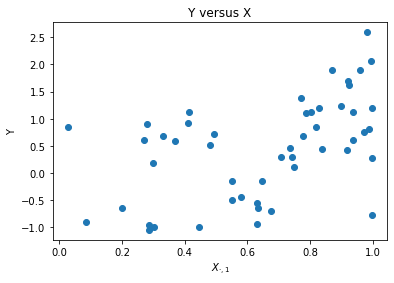

In [9]:
plt.scatter(x_train[:,0], y_train)
plt.xlabel('$X_{\cdot,1}$')
plt.ylabel('Y')
plt.title('Y versus X')

# Run LACQR

Define model hyperparameters

In [10]:
nn_params = {'dropout':0, 'epochs':1000, 'hidden_size':100, 'lr':1e-3, 'batch_norm':True, 
             'batch_size':2, 'normalize':True, 'weight_decay':0, 'epoch_model_tracking':True, 
             "running_batch_norm":True, "train_first_batch_norm":True, "use_gpu":False}


Use uacqr class to compute all of our methods at once.

In [11]:
%%time
lacqr_results = uacqr(nn_params,
                     bootstrapping_for_uacqrp=False, B=999, random_state=42, uacqrs_agg='std', model_type='neural_net',
                     extraneous_quantiles=['mean'])
lacqr_results.fit(x_train, y_train)
lacqr_results.calibrate(x_calib, y_calib)
lacqr_results.evaluate(x_test, y_test)

CPU times: user 21.5 s, sys: 102 ms, total: 21.6 s
Wall time: 21.6 s


{'interval_score_loss': {'UACQR-P': 2.8930417333668554,
  'UACQR-S': 2.865112824658916,
  'CQR': 3.515663455466911,
  'CQR-r': 5.363771418848887,
  'Base': 4.974076977702421},
 'test_coverage': {'UACQR-P': 0.9075,
  'UACQR-S': 0.91375,
  'CQR': 0.86125,
  'CQR-r': 0.925,
  'Base': 0.6225},
 'average_length_test': {'UACQR-P': 2.3640091,
  'UACQR-S': 2.376457,
  'CQR': 2.3796585,
  'CQR-r': 4.412216,
  'Base': 1.3223859}}

# Figure 1

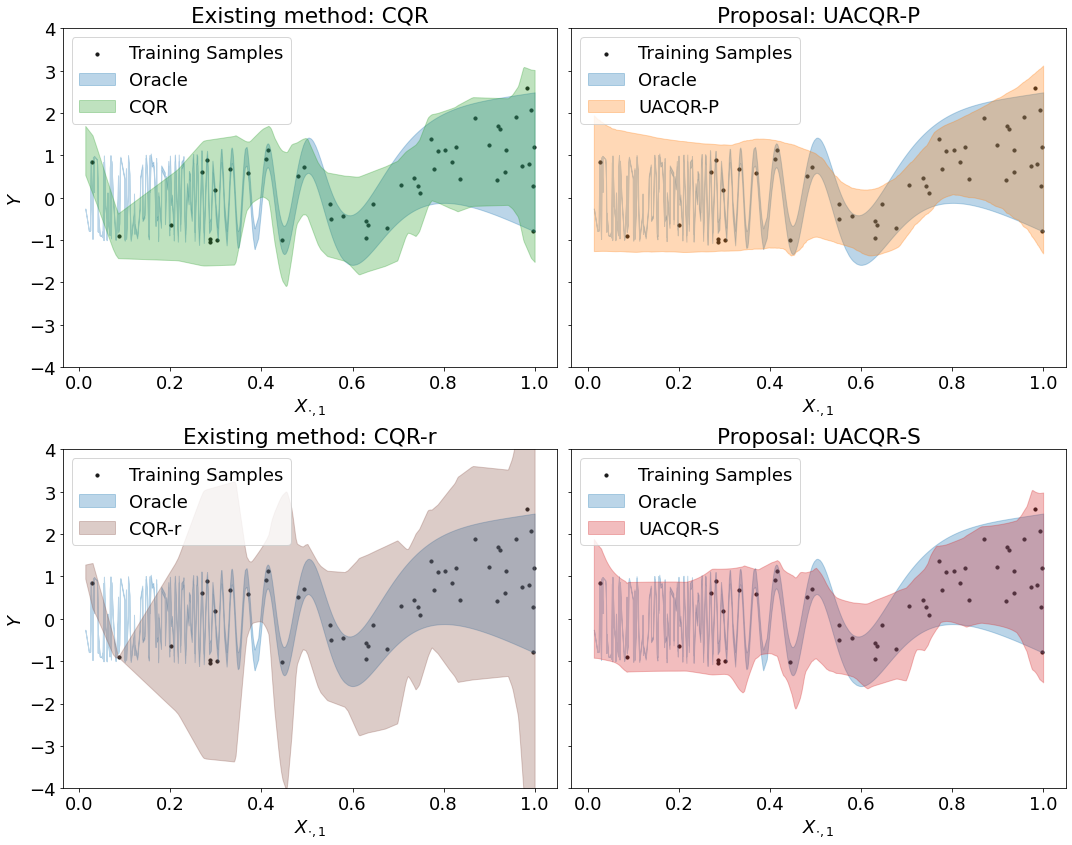

In [12]:
lacqr_results.plot_simple(cond_exp, noise_sd_fn,
                         xlabel='$X_{\cdot,1}$', expanded=True)
plt.tight_layout()
plt.savefig('figure_1_aistats.pdf')

# Figure 2

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
CPU times: user 53min 11s, sys: 3.28 s, total: 53min 14s
Wall time: 53min 15s


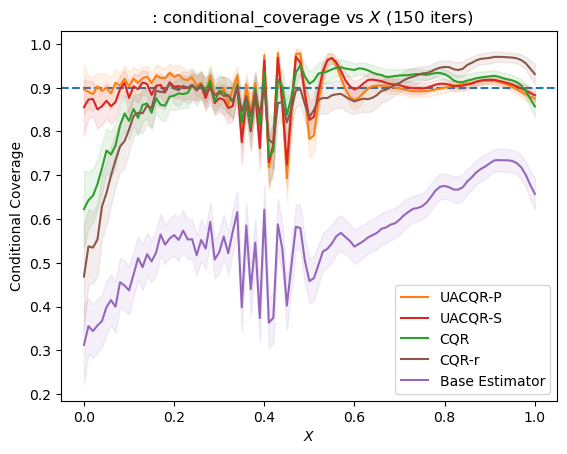

In [13]:
%%time
sim_results = experiment(cond_exp=cond_exp, noise_sd_fn=noise_sd_fn, x_dist=x_dist, n=n, p=p, T=T, 
           var_name='p', var_list=[1], 
           fast_uacqr=True, model_type='neural_net', S=150, B=999, fixed_model_params=nn_params,
                metric='conditional_coverage', uacqrs_agg='std',
                        extraneous_quantiles=['mean'], random_state=0)

sim_results.plot(metric='conditional_coverage', title_prefix=' ')

In [14]:
sim_results.save('figure_2_aistats.pkl')

In [15]:
sim_results = experiment(file_name='setting_5_150_iters_redux_train_first.pkl')

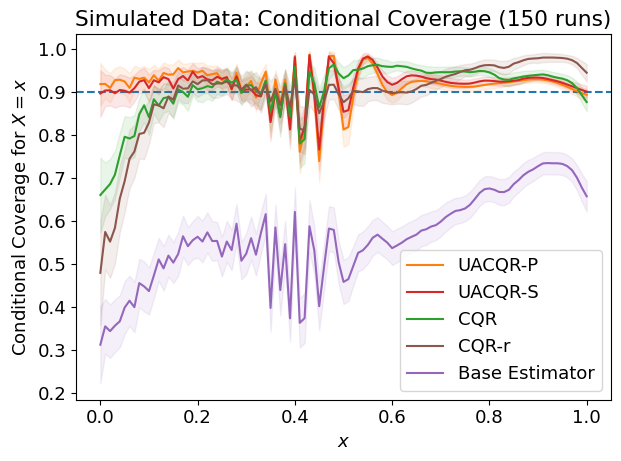

In [16]:
sim_results.plot(metric='conditional_coverage', custom_title='Simulated Data: Conditional Coverage (150 runs)', bigger_font=13)
plt.xlabel('$x$')
plt.ylabel('Conditional Coverage for $X=x$')
plt.tight_layout()
plt.savefig('figure_2_aistats.pdf')